## TM test of first order and for complex media
In the TE polarization, we have demonstrated that quadrant sorting works. However, in the TM polarization, a naive quadrant sort seems to be ineffective, specifically when any of the $\epsilon <0$.

However, since we know what the correct answer should look like, it appears that the correct sorting procedure is simple.
1. Any real k MUST BE OF ONE SIGN ONLY (POSITIVE)
2. pure imaginaries must be of ONE SIGN ONLY (POSITIVE)
3. nonzero real and nonzero imaginary k must come in complex conjugate pairs (so in $k^2$ space, they correspond to two separate eigenvalues)


In [1]:
## same as the analytic case but with the fft
import numpy as np
import sys
sys.path.append('/Users/nathanzhao/src/Rigorous-Coupled-Wave-Analysis')

import matplotlib.pyplot as plt
from numpy.linalg import cond
import cmath;
from scipy.fftpack import fft, fftfreq, fftshift, rfft
from scipy import linalg as LA
from numpy.linalg import solve as bslash
from RCWA_1D_functions.grating_fft.grating_conv import *


In [2]:
def nonHermitianEigenSorter(eigenvalues):
    N = len(eigenvalues);
    sorted_indices=[];
    sorted_eigs = [];
    for i in range(N):
        eig = eigenvalues[i];
        if(np.real(eig)>0 and np.imag(eig) == 0):
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)==0 and np.imag(eig) > 0): 
            sorted_indices.append(i); sorted_eigs.append(eig);
        elif(np.real(eig)>0 and abs(np.imag(eig)) > 0): 
            sorted_indices.append(i); sorted_eigs.append(eig);
    return sorted_eigs, sorted_indices;

def eigenMatcher():
    return;

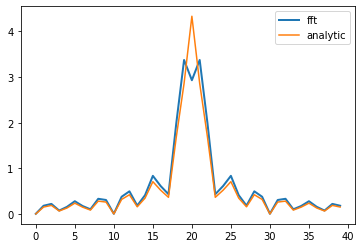

/Users/nathanzhao/anaconda3/lib/python3.7/site-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


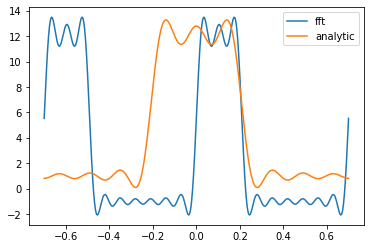

In [3]:
# Moharam et. al Formulation for stable and efficient implementation for RCWA
plt.close("all")
'''
1D TM implementation of PLANAR DIFFRACTiON
STILL NOT WORKING YET

only: sign convention is exp(-ikr) (is the positive propagating wave), so loss is +  not - 
source for fourier decomps is from the paper: Formulation for stable and efficient implementation of
the rigorous coupled-wave analysis of binary gratings by Moharam et. al
'''

L0 = 1e-6;
e0 = 8.854e-12;
mu0 = 4*np.pi*1e-8;
fill_factor = 0.3; # 50% of the unit cell is the ridge material


num_ord = 10; #INCREASING NUMBER OF ORDERS SEEMS TO CAUSE THIS THING TO FAIL, to many orders induce evanescence...particularly
               # when there is a small fill factor
PQ = 2*num_ord+1;
indices = np.arange(-num_ord, num_ord+1)

n_ridge = 3.48; #3.48;              # ridge
n_groove = 1;                # groove (unit-less)
lattice_constant = 0.7;  # SI units
# we need to be careful about what lattice constant means
# in the gaylord paper, lattice constant exactly means (0, L) is one unit cell


d = 0.46;               # thickness, SI units

Nx = 2*256;
eps_r = -n_groove**2*np.ones((2*Nx, 1)); #put in a lot of points in eps_r
border = int(2*Nx*fill_factor);
eps_r[0:border] = n_ridge**2;


fft_fourier_array = grating_fft(eps_r);
x = np.linspace(-lattice_constant,lattice_constant,2*Nx);
period = lattice_constant;
fft_reconstruct = fourier_reconstruction_general(x, period, num_ord, fft_fourier_array);

fourier_array_analytic = grating_fourier_array(Nx, fill_factor, n_ridge, -n_groove);
analytic_reconstruct = fourier_reconstruction(x, period, num_ord, n_ridge, -n_groove, fill_factor)


plt.figure();
plt.plot(np.abs(fft_fourier_array[Nx-20:Nx+20]), linewidth=2)
plt.plot(np.abs(fourier_array_analytic[Nx-20:Nx+20]));
plt.legend(('fft', 'analytic'))
plt.show()

plt.figure();
plt.plot(x,fft_reconstruct)
plt.plot(x,analytic_reconstruct);
plt.legend(['fft', 'analytic'])
plt.show()


In [4]:

##construct convolution matrix
E = np.zeros((2 * num_ord + 1, 2 * num_ord + 1)); E = E.astype('complex')
p0 = Nx; #int(Nx/2);
p_index = np.arange(-num_ord, num_ord + 1);
q_index = np.arange(-num_ord, num_ord + 1);
fourier_array = fft_fourier_array;#fourier_array_analytic;
detected_pffts = np.zeros_like(E);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    row_index = p_index[prow];
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        detected_pffts[prow, pcol] = pfft;
        E[prow, pcol] = fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

## FFT of 1/e;
inv_fft_fourier_array = grating_fft(1/eps_r);
##construct convolution matrix
E_conv_inv = np.zeros((2 * num_ord + 1, 2 * num_ord + 1));
E_conv_inv = E_conv_inv.astype('complex')
p0 = Nx;
p_index = np.arange(-num_ord, num_ord + 1);
for prow in range(2 * num_ord + 1):
    # first term locates z plane, 2nd locates y coumn, prow locates x
    for pcol in range(2 * num_ord + 1):
        pfft = p_index[prow] - p_index[pcol];
        E_conv_inv[prow, pcol] = inv_fft_fourier_array[p0 + pfft];  # fill conv matrix from top left to top right

print(E_conv_inv.shape);
print(E.shape)

(21, 21)
(21, 21)


## Observations to note
We can see that floating point precision can completely alter the sign when we take a square root of the beigenvals.

In [10]:
## IMPORTANT TO NOTE: the indices for everything beyond this points are indexed from -num_ord to num_ord+1

## alternate construction of 1D convolution matrix
zeros = np.zeros((PQ, PQ))

I = np.eye(2 * num_ord + 1)
## simulation parameters
theta = (0)*np.pi/180;
spectra = list();
spectra_T = list();

wavelength_scan = np.linspace(0.5,2.3,100)
## construct permittivity harmonic components E
#fill factor = 0 is complete dielectric, 1 is air

# E is now the convolution of fourier amplitudes
for wvlen in wavelength_scan:
    j = cmath.sqrt(-1);
    lam0 = wvlen;     k0 = 2 * np.pi / lam0; #free space wavelength in SI units
    print('wavelength: ' + str(wvlen));
    ## =====================STRUCTURE======================##

    ## Region I: reflected region (half space)
    n1 = 1;#cmath.sqrt(-1)*1e-12; #apparently small complex perturbations are bad in Region 1, these shouldn't be necessary

    ## Region 2; transmitted region
    n2 = 1;

    #from the kx_components given the indices and wvln
    kx_array = k0*(n1*np.sin(theta) + indices*(lam0 / lattice_constant)); #0 is one of them, k0*lam0 = 2*pi
    k_xi = kx_array;
    ## IMPLEMENT SCALING: these are the fourier orders of the x-direction decomposition.
    KX = np.diag((k_xi/k0)); #singular since we have a n=0, m= 0 order and incidence is normal

    ## construct matrix of Gamma^2 ('constant' term in ODE):
    B = (KX@bslash(E, KX) - I); #conditioning of this matrix is not bad, A SHOULD BE SYMMETRIC

    AO = np.block([[zeros, np.linalg.inv(E_conv_inv)],[B, zeros]])
    beigenvals, bigW = LA.eig(AO);
    print('conditioning of AO: %d'%np.linalg.cond(AO))
#     print('conditioning of big block: '+str(np.linalg.cond(AO)))
    #try rounding...
    rounded_beigenvals = np.array([round(i,10) for i in beigenvals])
    #print(rounded_beigenvals)
#     quadrant_sort = [1 if np.real(i)>=0 and np.imag(i)>=0 else 0 for i in rounded_beigenvals];
#     sorted_indices = np.nonzero(quadrant_sort)[0]
#     print(len(sorted_indices))
    sorted_eigs, sorted_indices =nonHermitianEigenSorter(rounded_beigenvals)
#     print(sorted_indices)
#     print(len(sorted_indices))
    sorted_eigenmodes = bigW[:,sorted_indices];
    #print(sorted_eigenmodes)
    #adding real and imaginary parts seems to work...
    sorted_eigenvals = beigenvals[sorted_indices]
    
    
    Wp = sorted_eigenmodes[0:PQ:,0:PQ]
    eigenvals_wp = (sorted_eigenvals[0:PQ]);    

    eigenvals, W = LA.eig(np.linalg.inv(E_conv_inv)@B);
    #print(rounded_beigenvals)
    #print('big: '+str(eigenvals_wp))
    #print(np.sqrt(eigenvals))
    W = Wp;
    #we should be gauranteed that all eigenvals are REAL
    #eigenvals = eigenvals.astype('complex');
    Q = np.diag(eigenvals_wp); #Q should only be positive square root of eigenvals
    #Q = np.diag(np.sqrt(eigenvals))
    V = E_conv_inv@(W@Q); #H modes

#     plt.subplot(141)
#     plt.plot(np.real(beigenvals), np.imag(beigenvals), '.'); plt.title('1st'); plt.ylim([-4,4])
#     plt.subplot(142)
#     plt.plot(np.real(eigenvals_wp), (np.imag(eigenvals_wp)), '.r', markersize = 10)
#     plt.plot(np.real(np.sqrt(eigenvals)), (np.imag(np.sqrt(eigenvals))), '.g', markersize = 5)

#     plt.ylim([-4,4])
#     plt.subplot(143);
#     plt.plot(np.real(beigenvals**2), np.imag(beigenvals**2), 'x');
#     plt.plot(np.real(eigenvals), np.imag(eigenvals), '.'); plt.title('2nd')

#     plt.ylim([-4,4])
#     plt.subplot(144)
#     plt.plot(np.real(np.sqrt(beigenvals**2)), np.imag(np.sqrt(beigenvals**2)), 'x');

#     plt.plot(np.real(np.sqrt(eigenvals)), np.imag(np.sqrt(eigenvals)), '.g'); plt.title('sqrt 2nd')
#     plt.ylim([-4,4])
#     plt.show();
    
    ## this is the great typo which has killed us all this time
    X = np.diag(np.exp(-k0*np.diag(Q)*d)); #this is poorly conditioned because exponentiation
    ## pointwise exponentiation vs exponentiating a matrix

    ## observation: almost everything beyond this point is worse conditioned
    k_I = k0**2*(n1**2 - (k_xi/k0)**2);                 #k_z in reflected region k_I,zi
    k_II = k0**2*(n2**2 - (k_xi/k0)**2);   #k_z in transmitted region
    k_I = k_I.astype('complex'); k_I = np.sqrt(k_I);
    k_II = k_II.astype('complex'); k_II = np.sqrt(k_II);
    Z_I = np.diag(k_I / (n1**2 * k0 ));
    Z_II = np.diag(k_II /(n2**2 * k0));
    delta_i0 = np.zeros((len(kx_array),1));
    delta_i0[num_ord] = 1;
    n_delta_i0 = delta_i0*j*np.cos(theta)/n1;

    ## design auxiliary variables: SEE derivation in notebooks: RCWA_note.ipynb
    # we want to design the computation to avoid operating with X, particularly with inverses
    # since X is the worst conditioned thing

    O = np.block([
        [W, W],
        [V,-V]
    ]); #this is much better conditioned than S..
    f = I;
    g = j * Z_II; #all matrices
    fg = np.concatenate((f,g),axis = 0)
    ab = np.matmul(np.linalg.inv(O),fg);
    a = ab[0:PQ,:];
    b = ab[PQ:,:];

    term = X @ a @ np.linalg.inv(b) @ X;
    f = W @ (I+term);
    g = V@(-I+term);
    T = np.linalg.inv(np.matmul(j*Z_I, f) + g);
    T = np.dot(T, (np.dot(j*Z_I, delta_i0) + n_delta_i0));
    R = np.dot(f,T)-delta_i0; #shouldn't change
    T = np.dot(np.matmul(np.linalg.inv(b),X),T)

    ## calculate diffraction efficiencies
    #I would expect this number to be real...
    DE_ri = R*np.conj(R)*np.real(np.expand_dims(k_I,1))/(k0*n1*np.cos(theta));
    DE_ti = T*np.conj(T)*np.real(np.expand_dims(k_II,1)/n2**2)/(k0*np.cos(theta)/n1);

    #print(np.sum(DE_ri))
    spectra.append(np.sum(DE_ri)); #spectra_T.append(T);
    spectra_T.append(np.sum(DE_ti))




wavelength: 0.5
conditioning of AO: 807
wavelength: 0.5181818181818182
conditioning of AO: 594
wavelength: 0.5363636363636364
conditioning of AO: 496
wavelength: 0.5545454545454546
conditioning of AO: 605
wavelength: 0.5727272727272728
conditioning of AO: 755
wavelength: 0.5909090909090909
conditioning of AO: 973
wavelength: 0.6090909090909091
conditioning of AO: 1321
wavelength: 0.6272727272727272
conditioning of AO: 1963
wavelength: 0.6454545454545455
conditioning of AO: 3539
wavelength: 0.6636363636363636
conditioning of AO: 13460
wavelength: 0.6818181818181819
conditioning of AO: 8517
wavelength: 0.7
conditioning of AO: 3397
wavelength: 0.7181818181818181
conditioning of AO: 2184
wavelength: 0.7363636363636363
conditioning of AO: 1640
wavelength: 0.7545454545454545
conditioning of AO: 1333
wavelength: 0.7727272727272727
conditioning of AO: 1135
wavelength: 0.7909090909090909
conditioning of AO: 997
wavelength: 0.8090909090909091
conditioning of AO: 895
wavelength: 0.827272727272727

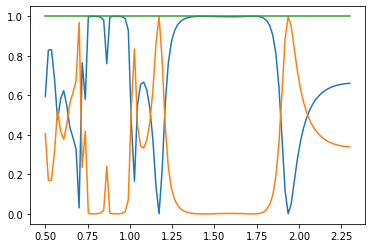

In [11]:
spectra = np.array(spectra);
spectra_T = np.array(spectra_T)
plt.figure();
plt.plot(wavelength_scan, spectra);
plt.plot(wavelength_scan, spectra_T)
plt.plot(wavelength_scan, spectra+spectra_T)
# plt.legend(['reflection', 'transmission'])
# plt.axhline(((3.48-1)/(3.48+1))**2,xmin=0, xmax = max(wavelength_scan))
# plt.axhline(((3.48-1)/(3.48+1)),xmin=0, xmax = max(wavelength_scan), color='r')
#
plt.show()


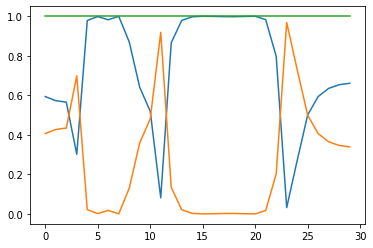

In [7]:
plt.plot(spectra)
plt.plot(spectra_T)
plt.plot(np.array(spectra)+np.array(spectra_T))
